# Finding Nash Equilibriums 

I've always heard about to player games in game theory. I like the idea that the players could find nash equilibriums by taking the opponents last move into account and changing thier strategy accordingly. 
Player's strategy can be represented by a probability distribution over tensors. Every round the player can update thier strategy based on thier loss. They should make small updates so as to not overcorrect. 


In [1]:


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming you have p_list defined somewhere above
def save_to_video(p_list, name):
    fig, ax = plt.subplots()

    def animate(i):
        # Fetch the tensor for this frame
        tensor_data = p_list[i]    
        tensor_data = (tensor_data * 255).byte()

        # Clear the current content of the axis and redraw the new frame
        ax.clear()
        ax.imshow(tensor_data, cmap='gray')
        ax.set_title(f"Frame {i}")

    # Assign the animation to a variable to prevent it from being garbage collected
    ani = animation.FuncAnimation(fig, animate, frames=len(p_list), repeat=True)

    ani.save(f'videos/{name}.mp4', writer='ffmpeg', fps=30)
    plt.close(fig)


def show_video(name):
    return HTML(f"""
        <video width="320" height="240" controls>
            <source src="videos/{name}.mp4" type="video/mp4">
        </video>
        """)


In [2]:

import torch

import matplotlib.pyplot as plt
import matplotlib.animation as animation

def solve(game, iter=100, alpha=.05, vid_name=None):
    q = torch.randn(game.size()[0],requires_grad=True)
    p = torch.randn(game.size()[1], requires_grad=True)
    l1_list, l2_list, p_list = [], [],[]

    def update(l1, l2, p):
        l1_list.append(l1), l2_list.append(l2), p_list.append(p)


    alpha = 0.1
    for i in range(iter):
        q_ten = torch.softmax(q, dim=0)
        p_ten = torch.softmax(p,dim=0)

        l1 = q_ten @ (game @ torch.tensor([1.,0])) @ p_ten
        l2 = q_ten @ (game @ torch.tensor([0,1.])) @ p_ten
        with torch.no_grad():
            update(l1.data.numpy().copy(), l2.data.numpy().copy(), (p_ten.view(-1,1) @ q_ten.view(1,-1)))


        l1.backward(retain_graph=True)
        with torch.no_grad():
            q.data.add_(alpha * q.grad.data)
            q.grad.zero_()
            p.grad.zero_()

        l2.backward(retain_graph=True)
        with torch.no_grad():
            p.data.add_(alpha * p.grad.data)
            p.grad.zero_()
            q.grad.zero_()  

    r = range(len(l1_list))
    plt.title('loss')
    plt.plot(r, l1_list, label='l1')
    plt.plot(r, l2_list, label='l2')
    plt.legend()
    plt.show()

    if vid_name:
        save_to_video(p_list, vid_name)






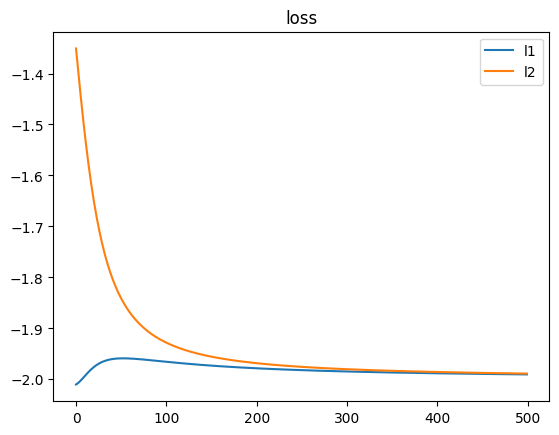

In [3]:
# Prisoners del
game = torch.tensor([
    [[-1,-1],[-3,0]]
    ,[[0, -3],[-2,-2]]
    ],dtype=torch.float)
solve(game, iter=500, vid_name='prisoner')


In [4]:
show_video('prisoner')

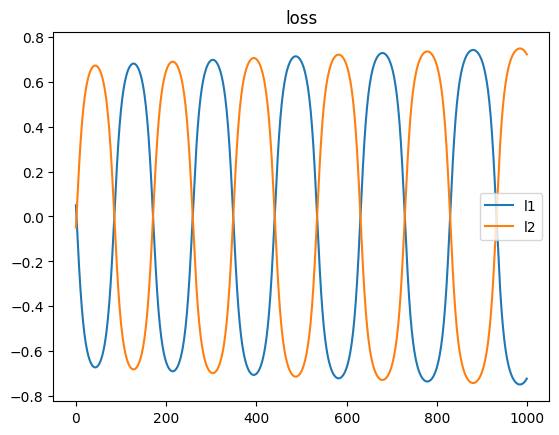

In [5]:
# Mathcing pennies

game = torch.tensor([
    [[1,-1],[-1,1]]
    ,[[-1, 1],[1,-1]]
    ],dtype=torch.float)
solve(game,iter=1000, vid_name='penny')


In [6]:
show_video('penny')

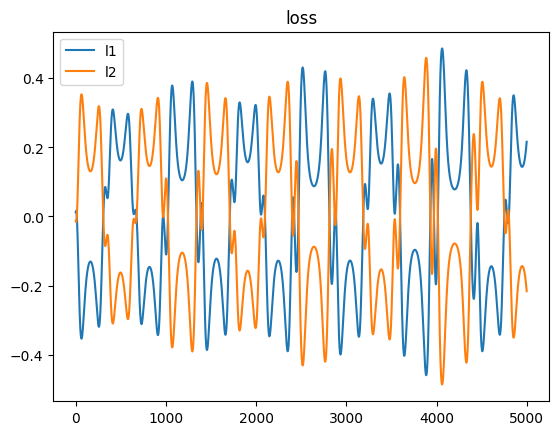

In [7]:
# Rock paper scissors
game = torch.tensor([
    [[0,0],[1,-1], [-1,1]]
   ,[[-1,1],[0,0], [1,-1]]
   ,[[1,-1],[-1,1], [0,0]]
    ],dtype=torch.float)
solve(game, iter=5000, alpha=.1, vid_name='rps')



In [8]:
show_video('rps')